In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, BaggingRegressor


In [402]:
elec = pd.read_csv('../output/charging-stations-population.csv', index_col='Unnamed: 0')
aq = pd.read_csv('../output/air_quality_by_state.csv')

In [403]:
elec.isnull().sum()

state              0
year               0
population         0
biodiesel          0
cng                0
e85                0
electric           0
hydrogen           0
lng                0
propane            0
total              0
electric_by_pop    0
dtype: int64

In [404]:
elec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state            720 non-null    object 
 1   year             720 non-null    int64  
 2   population       720 non-null    float64
 3   biodiesel        720 non-null    float64
 4   cng              720 non-null    float64
 5   e85              720 non-null    float64
 6   electric         720 non-null    float64
 7   hydrogen         720 non-null    float64
 8   lng              720 non-null    float64
 9   propane          720 non-null    float64
 10  total            720 non-null    float64
 11  electric_by_pop  720 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 73.1+ KB


In [405]:
aq = aq[aq.year > 2010]
elec = elec[elec.year > 2010]

In [406]:
aq = aq.replace('Alaska', np.nan).dropna()
aq = aq.replace('Hawaii', np.nan).dropna()
aq = aq.replace('District Of Columbia', np.nan).dropna()
aq = aq.replace('Virgin Islands', np.nan).dropna()


In [407]:
aq.shape, elec.shape

((576, 18), (576, 12))

In [408]:
elec_2 = elec[['state', 'year', 'electric_by_pop']]

In [409]:
df = aq.merge(elec_2, on=['state', 'year'])


In [410]:
elec_2.columns

Index(['state', 'year', 'electric_by_pop'], dtype='object')

In [411]:
obj = df[['state']]

In [412]:
ohe = OneHotEncoder(drop = 'first',
                    sparse = False,
                   handle_unknown='ignore')
obj = ohe.fit_transform(obj)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [413]:
obj = pd.DataFrame(obj, columns = ohe.get_feature_names_out())

In [414]:
obj

,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [415]:
to_drop = [
    'days_with_aqi',
    'pct_hazardous_days',
    'pct_very_unhealthy_days',
    'pct_unhealthy_days',
    'pct_unhealthy_for_sensitive_groups_days',
    'pct_moderate_days',
    '90th_percentile_aqi',
    'pct_good_days',
    'pct_days_pm10',
    'pct_days_pm2.5'
]

In [416]:
df.drop(columns = to_drop, inplace=True)

In [417]:
df_merged = pd.concat([obj,df], axis = 1)

In [418]:
df_merged

,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,...,state_Wyoming,state,year,max_aqi,median_aqi,pct_days_co,pct_days_no2,pct_days_ozone,pct_bad_days,electric_by_pop
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2011,111.526316,42.789474,0.000288,0.000000,0.566842,0.304273,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2012,110.235294,40.117647,0.000000,0.000000,0.597273,0.222823,0.008306
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2013,86.055556,37.388889,0.000000,0.000152,0.608364,0.146973,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2014,93.333333,38.166667,0.000000,0.001065,0.607310,0.170713,0.194143
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Alabama,2015,105.722222,39.333333,0.000000,0.001826,0.449222,0.221251,0.418354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,Wyoming,2018,106.500000,39.611111,0.000000,0.007854,0.779945,0.210523,2.094872
572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,Wyoming,2019,98.000000,38.833333,0.000000,0.004811,0.818655,0.128996,2.747257
573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,Wyoming,2020,131.705882,34.882353,0.000000,0.061075,0.654444,0.123657,2.977814
574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,Wyoming,2021,128.823529,36.294118,0.000323,0.061565,0.693599,0.216290,3.175244


In [419]:
X = df_merged.drop(columns = ['electric_by_pop', 'state', 'year'])
y = df_merged['electric_by_pop']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [420]:
base = [y_train.mean()]*len(y_train)

In [421]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)
knn.score(X_train, y_train), knn.score(X_test, y_test)

(0.3413041105759763, -0.10364176667060443)

In [422]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_train, y_train), knn.score(X_test, y_test)

(0.6069257944353867, -0.10364176667060443)

In [423]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [424]:
base_m = LinearRegression()
base_m.fit(X_train, base)

LinearRegression()

In [425]:
base_m.score(X_train_sc, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.0

In [426]:
base_m.score(X_test_sc, y_test)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


-0.0031470288908206356

In [427]:
knn = KNeighborsRegressor()

knn.fit(X_train_sc, y_train)
knn.score(X_train_sc, y_train), knn.score(X_test_sc, y_test)

(0.6802332631579662, 0.2685673707845305)

In [428]:
gs_knn = GridSearchCV(
    knn,
    param_grid={
        'n_neighbors' : [2,3,5,7,9,11],
        'weights' : ['uniform'],
        'p' : [2,5,6]
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

In [429]:
gs_knn.fit(X_train_sc, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [2, 5, 6],
                         'weights': ['uniform']},
             verbose=1)

In [430]:
gs_knn.best_estimator_

KNeighborsRegressor(n_neighbors=2)

In [431]:
gs_knn.best_estimator_.fit(X_train_sc, y_train)

KNeighborsRegressor(n_neighbors=2)

In [432]:
gs_knn.best_estimator_.score(X_train_sc, y_train)

0.8492080536147049

In [433]:
gs_knn.best_estimator_.score(X_test_sc, y_test)

0.34903720869737875

In [434]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_sc)
X_test_poly = poly.transform(X_test_sc)

In [435]:
gs_knn.fit(X_train_poly, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [2, 5, 6],
                         'weights': ['uniform']},
             verbose=1)

In [436]:
gs_knn.best_estimator_

KNeighborsRegressor(n_neighbors=2)

In [437]:
gs_knn.best_estimator_.score(X_train_poly, y_train)

0.8494437568051165

In [438]:
gs_knn.best_estimator_.score(X_test_poly, y_test)

0.36992329901772847

In [439]:
lr.fit(X_train_poly, y_train)

LinearRegression()

In [440]:
lr.score(X_train_poly, y_train)

0.964482308884535

In [441]:
lr.score(X_test_poly, y_test)

-2.0881046864831744e+18

In [442]:
ridge = RidgeCV()

ridge.fit(X_train, y_train)

RidgeCV()

In [443]:
ridge.score(X_train, y_train)

0.5933928541613352

In [444]:
ridge.score(X_test, y_test)

0.3788944674303627

In [445]:
gs_ridge = GridSearchCV(
    RidgeCV(),
    param_grid={
        'alphas' : np.arange(0.1, 10, 0.1)
    },
    cv = 5, 
    verbose = 1,
    n_jobs= -1
)

In [446]:
gs_ridge.fit(X_train_sc, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5, estimator=RidgeCV(), n_jobs=-1,
             param_grid={'alphas': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             verbose=1)

In [447]:
gs_ridge.best_estimator_.score(X_train_sc, y_train), gs_ridge.best_estimator_.score(X_test_sc, y_test)

(0.6069218052409229, 0.3958931711781456)

In [448]:
randf = RandomForestRegressor()

In [449]:
gs_randf = GridSearchCV(
    randf,
    param_grid={
        'n_estimators' : [80,90,100, 110,120],
        'max_depth' : [2,3,5,7],
        'min_samples_split' : [6,10, 15]
    },
    verbose = 1,
    cv = 4,
    n_jobs = -1
)

In [450]:
gs_randf.fit(X_train_sc, y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


GridSearchCV(cv=4, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_split': [6, 10, 15],
                         'n_estimators': [80, 90, 100, 110, 120]},
             verbose=1)

In [451]:
gs_randf.best_estimator_

RandomForestRegressor(max_depth=7, min_samples_split=15, n_estimators=80)

In [452]:
gs_randf.best_estimator_.fit(X_train_sc, y_train)
gs_randf.best_estimator_.score(X_train_sc, y_train), gs_randf.best_estimator_.score(X_test_sc, y_test)

(0.5231031587386892, 0.37546636809878153)

In [453]:
bagging = BaggingRegressor(base_estimator=gs_randf.best_estimator_,n_estimators = 80)
bagging.fit(X_train_sc, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=7,
                                                      min_samples_split=15,
                                                      n_estimators=80),
                 n_estimators=80)

In [454]:
bagging.score(X_train_sc, y_train), bagging.score(X_test_sc, y_test)

(0.5219977323465848, 0.35138705267841164)

In [455]:
stack = StackingRegressor(
   [('bagging', bagging),
   ('gs_randf', gs_randf.best_estimator_)],
    final_estimator=gs_ridge
)

In [456]:
stack.fit(X_train_sc, y_train)

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.

Fitting 5 folds for each of 99 candidates, totalling 495 fits


StackingRegressor(estimators=[('bagging',
                               BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=7,
                                                                                     min_samples_split=15,
                                                                                     n_estimators=80),
                                                n_estimators=80)),
                              ('gs_randf',
                               RandomForestRegressor(max_depth=7,
                                                     min_samples_split=15,
                                                     n_estimators=80))],
                  final_estimator=GridSearchCV(cv=5, estimator=RidgeCV(),
                                               n_jobs=-1,
                                               param_grid={'alphas': array([0.1, 0.2, 0...
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
                                               verbose=1))

In [457]:
stack.score(X_train_sc, y_train)

0.5301024022158125

In [458]:
stack.score(X_test_sc, y_test)

0.36639070092675663

In [470]:
arizona = df[df.state == 'Arizona']
arizona_obj = arizona[['state']]
arizona_num = arizona.drop(columns = ['state', 'year', 'electric_by_pop'])

arizona_2 = arizona_obj


arizona_obj = arizona_obj.reset_index().drop(columns='index')
arizona_2 = arizona_2.reset_index().drop(columns='index')
arizona = arizona.reset_index().drop(columns='index')

arizona_obj.loc[12,:] = ['Arizona']
arizona_obj.loc[13,:] = ['Arizona']
arizona_obj.loc[14,:] = ['Arizona']
arizona_2.loc[12,:] = ['Arizona']
arizona_2.loc[13,:] = ['Arizona']
arizona_2.loc[14,:] = ['Arizona']


arizona_num = arizona_num.reset_index().drop(columns='index')

arizona_num.loc[12,:] = arizona_num.loc[11,:] * 0.9
arizona_num.loc[13,:] = arizona_num.loc[12,:] * 0.9
arizona_num.loc[14,:] = arizona_num.loc[13,:] * 0.9

arizona_2['pct_bad_days'] = arizona_num.pct_bad_days
arizona_2['electric_by_pop'] = arizona.electric_by_pop



In [471]:
arizona_obj = ohe.transform(arizona_obj)
arizona_obj = pd.DataFrame(arizona_obj, columns = obj.columns)

In [472]:
arizona_test = pd.concat([arizona_obj, arizona_num], axis = 1)

In [473]:
pd.DataFrame(arizona_test.loc[12,:].array.reshape(1, -1), columns = arizona_test.columns)

,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,state_Idaho,state_Illinois,...,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,max_aqi,median_aqi,pct_days_co,pct_days_no2,pct_days_ozone,pct_bad_days
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.992308,39.115385,0.0,0.0,0.538429,0.284505


In [474]:
arizona_2.loc[12,:] = ['Arizona', arizona_2.loc[12,'pct_bad_days'] * 0.9,
                       ridge.predict(pd.DataFrame(arizona_test.loc[12,:].array.reshape(1, -1), 
                                                  columns = arizona_test.columns))]
arizona_2.loc[13,:] = ['Arizona', arizona_2.loc[13,'pct_bad_days'] * 0.9,
                       ridge.predict(pd.DataFrame(arizona_test.loc[12,:].array.reshape(1, -1), 
                                                  columns = arizona_test.columns))]
arizona_2.loc[14,:] = ['Arizona', arizona_2.loc[14,'pct_bad_days'] * 0.9,
                       ridge.predict(pd.DataFrame(arizona_test.loc[12,:].array.reshape(1, -1), 
                                                  columns = arizona_test.columns))]

/Users/bede/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/Users/bede/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or s

In [477]:
arizona_2['year'] = [year for year in range(2011, 2026)]

In [478]:
arizona_2

,state,pct_bad_days,electric_by_pop,year
0,Arizona,0.316087,0.016995,2011
1,Arizona,0.372480,0.054920,2012
2,Arizona,0.333909,0.057291,2013
3,Arizona,0.318739,1.160404,2014
4,Arizona,0.249845,1.191857,2015
5,Arizona,0.269117,1.463751,2016
6,Arizona,0.353233,1.513343,2017
7,Arizona,0.303651,1.712763,2018
8,Arizona,0.262594,2.027830,2019
9,Arizona,0.289007,2.476343,2020


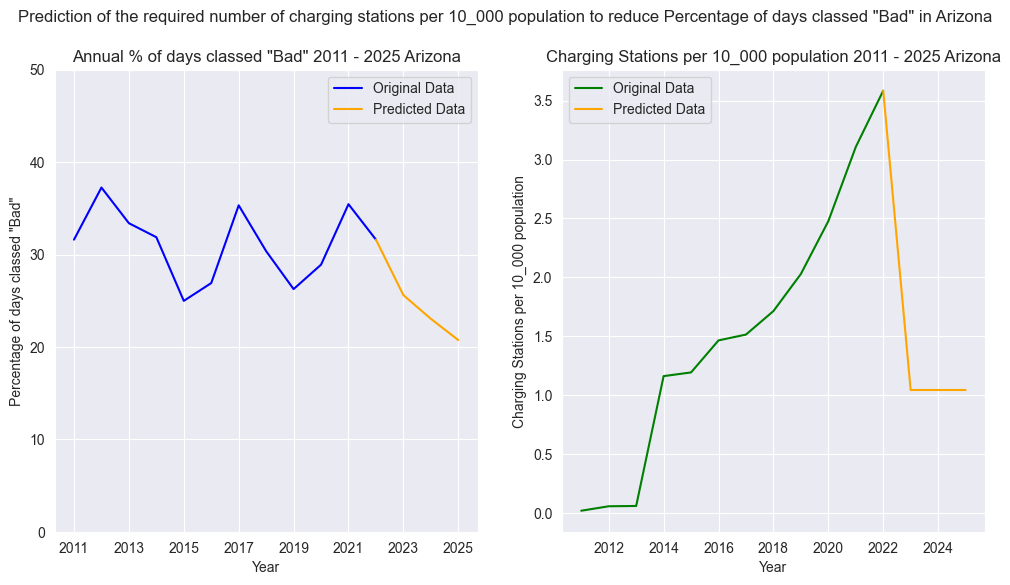

In [482]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

plt.suptitle('Prediction of the required number of charging stations per 10_000 population to reduce Percentage of days classed "Bad" in Arizona')

sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year < 2023].pct_bad_days * 100,
            ax = axs[0], color = 'b', label = 'Original Data')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year > 2021].pct_bad_days * 100,
            ax = axs[0], color = 'orange', label = 'Predicted Data')

axs[0].set_ylim(0,50)

axs[0].set_xticks([2011, 2013, 2015, 2017, 2019, 2021, 2023, 2025])
axs[0].set(title = 'Annual % of days classed "Bad" 2011 - 2025 Arizona', xlabel = 'Year', ylabel = 'Percentage of days classed "Bad"')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year < 2023].electric_by_pop,
            ax = axs[1], color = 'g', label = 'Original Data')
sns.lineplot(x = arizona_2.year,
            y = arizona_2[arizona_2.year > 2021].electric_by_pop,
            ax = axs[1], color = 'orange', label = 'Predicted Data')
axs[1].set(title = 'Charging Stations per 10_000 population 2011 - 2025 Arizona', xlabel = 'Year',
          ylabel = 'Charging Stations per 10_000 population')
axs[0].legend();